In [16]:
!pip install datasets scikit-learn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [14]:
from datasets import load_dataset, concatenate_datasets

# Load full IMDb dataset
full_train = load_dataset("imdb", split="train")
full_test = load_dataset("imdb", split="test")

# Select 75 positive and 75 negative for training
train_pos = full_train.filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(75))
train_neg = full_train.filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(75))
train_dataset = concatenate_datasets([train_pos, train_neg])

# Select 25 positive and 25 negative for testing
test_pos = full_test.filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(25))
test_neg = full_test.filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(25))
test_dataset = concatenate_datasets([test_pos, test_neg])

# Separate texts and labels
train_texts = train_dataset["text"]
train_labels = train_dataset["label"]
test_texts = test_dataset["text"]
test_labels = test_dataset["label"]

print(f"Training samples: {len(train_texts)}, Pos: {train_labels.count(1)}, Neg: {train_labels.count(0)}")
print(f"Test samples: {len(test_texts)}, Pos: {test_labels.count(1)}, Neg: {test_labels.count(0)}")

Training samples: 150, Pos: 75, Neg: 75
Test samples: 50, Pos: 25, Neg: 25


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


# Convert text to bag-of-words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(train_texts)
X_test_bow = vectorizer.transform(test_texts)

# Train baseline model
baseline_model = LogisticRegression(max_iter=200)
baseline_model.fit(X_train_bow, train_labels)

baseline_preds = baseline_model.predict(X_test_bow)

# Accuracy
baseline_accuracy = accuracy_score(test_labels, baseline_preds)

# F1-score
baseline_f1 = f1_score(test_labels, baseline_preds)

print(f"Baseline Accuracy:{baseline_accuracy:.4f}")
print(f"Baseline F1:{baseline_f1:.4f}")

Baseline Accuracy:0.6800
Baseline F1:0.6667


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

# ----------------------------
# 1. Preprocessing + 2. Embedding + 3. Classifier combined
# ----------------------------
improved_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,       # Convert text into numerical vector
        ngram_range=(1, 2),      # Enables unigram and bigrams to improves accuracy
        stop_words="english"     # Remove common words
    )),
    ("clf", LinearSVC())         # stronger classifier than Logistic Regression
])

# ----------------------------
# Train pipeline
# ----------------------------
improved_pipeline.fit(train_texts, train_labels)

# ----------------------------
# Predict and evaluate
# ----------------------------
improved_preds = improved_pipeline.predict(test_texts)

# Accuracy
improved_accuracy = accuracy_score(test_labels, improved_preds)

# F1-score
improved_f1 = f1_score(test_labels, improved_preds)

print(f"AI pipeline Accuracy:{improved_accuracy:.4f}")
print(f"AI Pipeline F1-score:{improved_f1:.4f}")

AI pipeline Accuracy:0.7000
AI Pipeline F1-score:0.7368


In [18]:
examples = [
    {"text": "This movie was extremely boring", "Tlabel": "Negative","val":"0"},
    {"text": "I really love this movie.", "Tlabel": "Positive", "val":"1"},
    {"text": "Great! another sequel no one asked for", "Tlabel": "Negative", "val":"0"},
    {"text": "Comfusing at first, but very enjoyable", "Tlabel": "Positive", "val":"1"}
]

for ex in examples:
    baseline_pred = baseline_model.predict(vectorizer.transform([ex["text"]]))[0]
    ai_pred = improved_pipeline.predict([ex["text"]])[0]
    print(f"Text: {ex['text']}")
    print(f"True Label: {ex['Tlabel']}")
    print(f"Baseline Prediction: {baseline_pred}")
    print(f"AI Pipeline Prediction: {ai_pred}")
    if str(baseline_pred) != ex["val"] and str(ai_pred) == ex["val"]:
        print("Comment: AI pipeline corrected the baseline mistake.\n")
    elif str(baseline_pred) == ex["val"] and str(ai_pred) != ex["val"]:
        print("Comment: AI pipeline made a mistake while baseline was correct.\n")
    elif str(baseline_pred) == ex["val"] and str(ai_pred) == ex["val"]:
        print("Comment: Both models correct.\n")
    else:
        print("Comment: Both models failed / other case.\n")

Text: This movie was extremely boring
True Label: Negative
Baseline Prediction: 0
AI Pipeline Prediction: 0
Comment: Both models correct.

Text: I really love this movie.
True Label: Positive
Baseline Prediction: 0
AI Pipeline Prediction: 1
Comment: AI pipeline corrected the baseline mistake.

Text: Great! another sequel no one asked for
True Label: Negative
Baseline Prediction: 0
AI Pipeline Prediction: 1
Comment: AI pipeline made a mistake while baseline was correct.

Text: Comfusing at first, but very enjoyable
True Label: Positive
Baseline Prediction: 0
AI Pipeline Prediction: 1
Comment: AI pipeline corrected the baseline mistake.



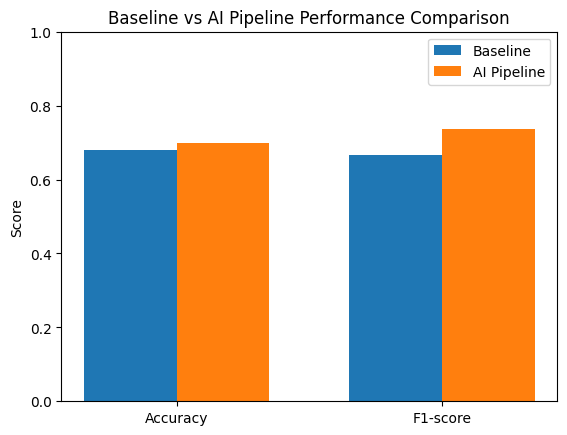

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics
metrics = ["Accuracy", "F1-score"]

baseline_scores = [
    baseline_accuracy,
    baseline_f1
]

ai_scores = [
    improved_accuracy,
    improved_f1
]

# Bar positions
x = np.arange(len(metrics))
width = 0.35

# Plot
plt.bar(x - width/2, baseline_scores, width, label="Baseline")
plt.bar(x + width/2, ai_scores, width, label="AI Pipeline")

# Labels and title
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Baseline vs AI Pipeline Performance Comparison")
plt.legend()

plt.show()